In [341]:
%matplotlib notebook

In [342]:
from types import SimpleNamespace

import matplotlib.animation as anm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

COLUMN = SimpleNamespace(**{
    'PLAY_TYPE': 'specialTeamsPlayType',
    'SPECIAL_TEAMS_RESULT': 'specialTeamsResult',
    'PLAY_RESULT': 'playResult', # Net difference in field position
    'POSITION': 'position',
    'PLAY_EVENT': 'event',
    'GAME_ID': 'gameId',
    'PLAY_ID': 'playId',
    'GUNNERS': 'gunners',
    'GUNNER_LIST': 'gunnerList',
    'HOME_TEAM': 'homeTeamAbbr',
    'VISITOR_TEAM': 'visitorTeamAbbr',
    'IS_GUNNER': 'isGunner',
    'JERSEY_NUMBER': 'jerseyNumber',
    'TEAM': 'team',
    'POSSESSION_TEAM': 'possessionTeam',
    'TIME': 'time',
    'NFL_ID': 'nflId',
    'RETURNER_ID': 'returnerId',
    'PRIMARY_RETURNER_ID': 'primaryReturnerId',
    'PLAYER_TEAM_ID': 'playerTeamId',
    'X': 'x',
    'Y': 'y',
    'COLOR': 'color',
    'FRAME': 'frame',
    'DISPLAY_NAME': 'displayName',
    'KICK_RETURN_YARDAGE': 'kickReturnYardage',
    'DISTANCE_FROM_SIDELINE': 'distanceFromSideline',
    'SORT_POSITION': 'sortPosition',
})

POSITION = SimpleNamespace(**{
    'KICKER': 'K',
    'PUNTER': 'P',
    'LONG_SNAPPER': 'LS',
})

PLAY_TYPE = SimpleNamespace(**{
    'FIELD_GOAL': 'Field Goal',
    'PUNT': 'Punt',
})

PLAY_EVENT = SimpleNamespace(**{
    'BALL_SNAP': 'ball_snap',
    'FG_ATTEMPT': 'field_goal_attempt',
    'PUNT': 'punt',
    'PUNT_RECEIVED': 'punt_received',
    'OUT_OF_BOUNDS': 'out_of_bounds',
    'PUNT_LAND': 'punt_land',
    'FAIR_CATCH': 'fair_catch',
    'PUNT_MUFFED': 'punt_muffed',
})

SPECIAL_TEAMS_RESULT = SimpleNamespace(**{
    'BLOCKED': 'Blocked Kick Attempt',
    'DOWNED': 'Downed',
    'KICK_GOOD': 'Kick Attempt Good',
    'KICK_NO_GOOD': 'Kick Attempt No Good',
    'RETURN': 'Return',
    'TOUCHBACK': 'Touchback',
    'FAIR_CATCH': 'Fair Catch',
    'MUFFED': 'Muffed',
    'OUT_OF_BOUNDS': 'Out of Bounds',
})

TEAM = SimpleNamespace(**{
    'HOME': 'home',
    'AWAY': 'away',
    'FOOTBALL': 'football',
})

In [343]:
games_df = pd.read_csv('input/games.csv')
players_df = pd.read_csv('input/players.csv')
plays_df = pd.read_csv('input/plays.csv')
pff_scouting_df = pd.read_csv('input/PFFScoutingData.csv')
tracking_2018_df = pd.read_csv('input/tracking2018.csv')
game_plays_df = pd.merge(games_df, plays_df, left_on=COLUMN.GAME_ID, right_on=COLUMN.GAME_ID)

In [344]:
game_plays_df = game_plays_df.dropna(subset=[COLUMN.RETURNER_ID])

def getPrimaryReturnerId(value):
    returners = str(value).split(';')
    return int(returners[0])

game_plays_df[COLUMN.PRIMARY_RETURNER_ID] = game_plays_df[COLUMN.RETURNER_ID] \
    .apply(getPrimaryReturnerId) \
    .astype('Int64')

tracking_2018_df[COLUMN.TIME] = pd.to_datetime(tracking_2018_df[COLUMN.TIME])
tracking_2018_df[COLUMN.JERSEY_NUMBER] = tracking_2018_df[COLUMN.JERSEY_NUMBER].astype('Int64')
tracking_2018_df[COLUMN.NFL_ID] = tracking_2018_df[COLUMN.NFL_ID].astype('Int64')

In [345]:
punt_tracking_2018_df = pd.merge(
    pff_scouting_df,
    tracking_2018_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)
punt_plays_df = game_plays_df[game_plays_df[COLUMN.PLAY_TYPE] == PLAY_TYPE.PUNT]
punt_tracking_2018_df = pd.merge(
    punt_tracking_2018_df,
    punt_plays_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)

In [346]:
conditions = [
    (punt_tracking_2018_df[COLUMN.TEAM] == 'home'),
    (punt_tracking_2018_df[COLUMN.TEAM] == 'away'),
]

values = [
    punt_tracking_2018_df[COLUMN.HOME_TEAM] + ' ' + punt_tracking_2018_df[COLUMN.JERSEY_NUMBER].astype(str),
    punt_tracking_2018_df[COLUMN.VISITOR_TEAM] + ' ' + punt_tracking_2018_df[COLUMN.JERSEY_NUMBER].astype(str),
]

punt_tracking_2018_df[COLUMN.PLAYER_TEAM_ID] = np.select(conditions, values)

def splitGunners(value):
    if value is None:
        return []
    gunners = str(value).split(';')
    return [gunner.strip() for gunner in gunners]

punt_tracking_2018_df[COLUMN.GUNNER_LIST] = punt_tracking_2018_df[COLUMN.GUNNERS].apply(splitGunners)

punt_tracking_2018_df[COLUMN.IS_GUNNER] = punt_tracking_2018_df.apply(
    lambda x: str(x[COLUMN.PLAYER_TEAM_ID]) in x[COLUMN.GUNNER_LIST],
    axis=1,
)

<IPython.core.display.Javascript object>


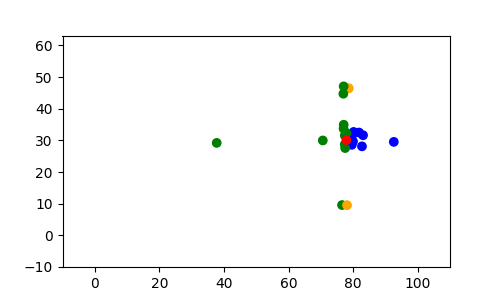

In [363]:
punt_tracking_2018_df.loc[:, COLUMN.FRAME] = punt_tracking_2018_df[[COLUMN.GAME_ID, COLUMN.TIME]] \
    .apply(tuple, axis=1) \
    .rank(ascending=True, method='dense')

conditions = [
    punt_tracking_2018_df[COLUMN.IS_GUNNER],
    punt_tracking_2018_df[COLUMN.TEAM] == TEAM.HOME,
    punt_tracking_2018_df[COLUMN.TEAM] == TEAM.AWAY,
    punt_tracking_2018_df[COLUMN.TEAM] == TEAM.FOOTBALL,
]
values = [
    'orange',
    'green',
    'blue',
    'red',
]
punt_tracking_2018_df.loc[:, COLUMN.COLOR] = np.select(conditions, values)

fig, ax = plt.subplots(figsize=(5, 3))
ax.set(xlim=(-10, 110), ylim=(-10, 63))
first_frame = punt_tracking_2018_df[punt_tracking_2018_df[COLUMN.FRAME] == 1]
c = first_frame[COLUMN.COLOR]
x = first_frame[COLUMN.X]
y = first_frame[COLUMN.Y]
scatter = ax.scatter(x, y, c=c)

def animate(i):
    filtered = punt_tracking_2018_df[punt_tracking_2018_df[COLUMN.FRAME] == i+1]
    c = filtered[COLUMN.COLOR]
    x = filtered[COLUMN.X]
    y = filtered[COLUMN.Y]
    data = np.c_[x, y]
    scatter.set_offsets(data)
    scatter.set_color(c)

animation = anm.FuncAnimation(
    fig,
    animate,
    interval=10,
    frames=int(punt_tracking_2018_df[COLUMN.FRAME].max()),
    repeat=True,
)
plt.show()

In [348]:
# Punt distance from sideline vs return distance
punt_tracking_2018_df['sidelineA'] = 53.3 - punt_tracking_2018_df[COLUMN.Y]
punt_tracking_2018_df['sidelineB'] = punt_tracking_2018_df[COLUMN.Y]
punt_tracking_2018_df[COLUMN.DISTANCE_FROM_SIDELINE] = punt_tracking_2018_df[['sidelineA', 'sidelineB']].min(axis=1)

<IPython.core.display.Javascript object>


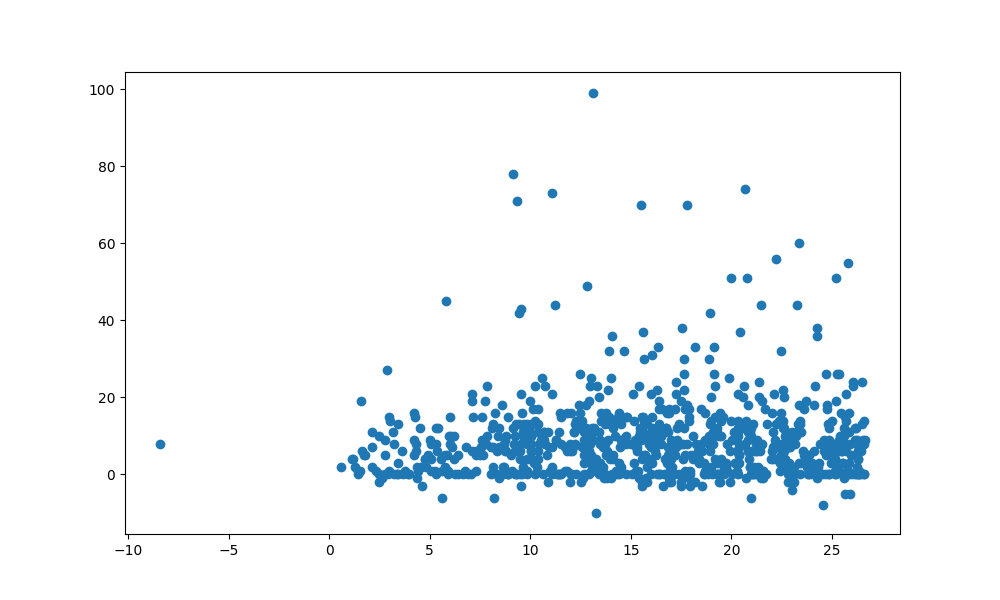

In [349]:
punt_received_football_only_df = punt_tracking_2018_df[
    (punt_tracking_2018_df[COLUMN.PLAY_EVENT] == PLAY_EVENT.PUNT_RECEIVED)
    & (punt_tracking_2018_df[COLUMN.TEAM] == 'football')
]
x = punt_received_football_only_df[COLUMN.DISTANCE_FROM_SIDELINE]
y = punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE]
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(x, y)
plt.show()

In [350]:
x.corr(y)

0.035468871186775344

In [351]:
punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE].mean()

8.923543689320388

In [352]:
punt_received_football_only_df['aboveAverageReturn'] = \
    punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE] > punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE].mean()
punt_received_football_only_df[[COLUMN.X, COLUMN.Y, COLUMN.DISTANCE_FROM_SIDELINE, COLUMN.KICK_RETURN_YARDAGE, 'aboveAverageReturn']]

/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_5364/3917194774.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  punt_received_football_only_df['aboveAverageReturn'] = \


,x,y,distanceFromSideline,kickReturnYardage,aboveAverageReturn
2893,72.61,39.18,14.12,5.0,False
7911,91.77,35.94,17.36,8.0,False
12720,82.02,42.04,11.26,9.0,True
19308,30.37,32.33,20.97,12.0,True
22523,36.61,44.87,8.43,-1.0,False
25778,98.16,52.11,1.19,4.0,False
28969,41.47,38.14,15.16,3.0,False
33188,79.88,28.12,25.18,51.0,True
36134,80.46,23.87,23.87,1.0,False
42490,41.74,25.41,25.41,6.0,False


<IPython.core.display.Javascript object>


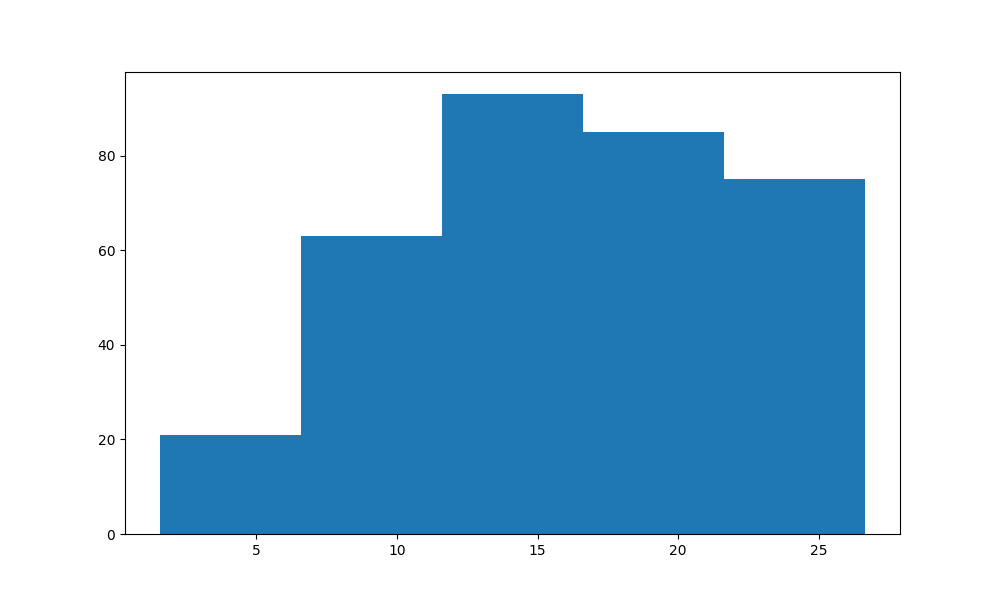

In [353]:
above_average_returns_df = punt_received_football_only_df[punt_received_football_only_df['aboveAverageReturn'] == True]
x = above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE]
bins = 5
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(x=x, bins=bins)
plt.show()

In [354]:
above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE].corr(above_average_returns_df[COLUMN.KICK_RETURN_YARDAGE])

0.04671642827966678

<IPython.core.display.Javascript object>


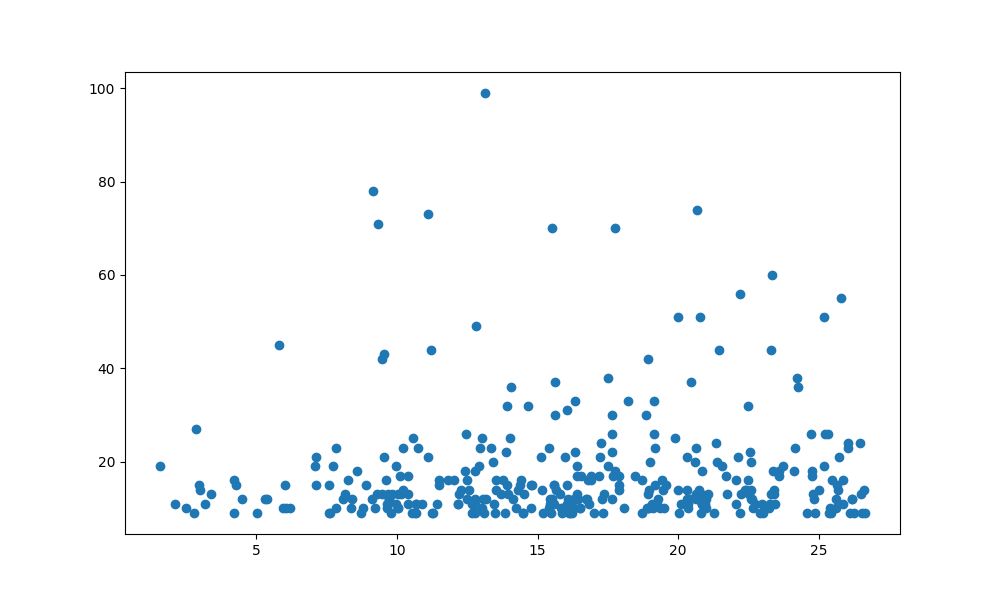

In [364]:
x = above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE]
y = above_average_returns_df[COLUMN.KICK_RETURN_YARDAGE]
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(x, y)
plt.show()

In [356]:
'''
Predict punt landing position based on pre-snap inputs (ball position)

Inputs:
  - Positions of all players and ball at time of snap (22 players + ball, x and y positions)
Outputs:
  - Ball landing position x, y
  
TODO:
  - Stack all 3 years of data
  - For inputs, filter tracking data to play event = ball_snap and special teams result
       is one of Return', 'Touchback', 'Fair Catch', 'Downed', 'Muffed', 'Out of Bounds'
  - For outputs, filter to football position when special teams result is one of Return', 'Touchback',
       'Fair Catch', 'Downed', 'Muffed', 'Out of Bounds'
       AND play event is one of punt_received, punt_land,
       fair_catch, punt_muffed
       AND team is football
  - Partition/sync inputs and outputs based on game id and play id
  - Partition data into training data and test data (80/20)
  - Use sklearn.linear_model.LinearRegression to train and test
  - Visualize results
  
A, B, C, D, E, F

A * x0 + B * x1 + C * x2 + D * x3 ... = ball landing position

                      SORT
x0 = ball x           1
x1 = ball y           2
x2 = punter x
x3 = punter y
x4 = returner x
x5 = returner y

y0 = ball landing x
y1 = ball landing y

football filter COLUMN.TEAM == 'football'
punter filter COLUMN.POSITION == 'P'
returner filter returnerId == nflId 
'''
special_teams_results = [
    SPECIAL_TEAMS_RESULT.RETURN,
    SPECIAL_TEAMS_RESULT.TOUCHBACK,
    SPECIAL_TEAMS_RESULT.FAIR_CATCH,
    SPECIAL_TEAMS_RESULT.DOWNED,
    SPECIAL_TEAMS_RESULT.MUFFED,
    SPECIAL_TEAMS_RESULT.OUT_OF_BOUNDS,
]
ball_land_events = [
    PLAY_EVENT.PUNT_RECEIVED,
    PLAY_EVENT.PUNT_LAND,
    PLAY_EVENT.FAIR_CATCH,
    PLAY_EVENT.PUNT_MUFFED,
]
punt_predict_df = punt_tracking_2018_df[
    punt_tracking_2018_df[COLUMN.SPECIAL_TEAMS_RESULT].isin(special_teams_results)
]

In [357]:
is_football = punt_predict_df[COLUMN.TEAM] == TEAM.FOOTBALL
is_punter = punt_predict_df[COLUMN.POSITION] == POSITION.PUNTER
is_returner = (~np.isnan(punt_predict_df[COLUMN.PRIMARY_RETURNER_ID])) \
    & (~np.isnan(punt_predict_df[COLUMN.NFL_ID])) \
    & (punt_predict_df[COLUMN.PRIMARY_RETURNER_ID] == punt_predict_df[COLUMN.NFL_ID])
inputs_df = punt_predict_df[
    (punt_predict_df[COLUMN.PLAY_EVENT] == PLAY_EVENT.BALL_SNAP)
    & ((is_football) | (is_punter) | (is_returner))
]

conditions = [
    (inputs_df[COLUMN.TEAM] == TEAM.FOOTBALL),
    (inputs_df[COLUMN.POSITION] == POSITION.PUNTER),
    np.where(inputs_df[COLUMN.PRIMARY_RETURNER_ID].fillna(-1) == inputs_df[COLUMN.NFL_ID].fillna(-2), True, False),
]
values = [1, 2, 3]
inputs_df[COLUMN.SORT_POSITION] = np.select(conditions, values)

inputs_df = inputs_df.sort_values(by=[COLUMN.GAME_ID, COLUMN.PLAY_ID, COLUMN.SORT_POSITION])

aggs = { 'x': lambda x: x.to_list(), 'y': lambda y: y.to_list() }
inputs_df = inputs_df.groupby([COLUMN.GAME_ID, COLUMN.PLAY_ID]).agg(aggs).reset_index()
inputs_df = inputs_df[
    (inputs_df[COLUMN.X].map(len) == 3)
    & (inputs_df[COLUMN.Y].map(len) == 3)
]

def merge_coordinates(df):
    return [
        df[COLUMN.X][0],
        df[COLUMN.Y][0],
        df[COLUMN.X][1],
        df[COLUMN.Y][1],
        df[COLUMN.X][2],
        df[COLUMN.Y][2],
    ]

inputs_df['features'] = inputs_df.apply(merge_coordinates, axis=1)

/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_5364/2827678063.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs_df[COLUMN.SORT_POSITION] = np.select(conditions, values)


In [358]:
outputs_df = punt_predict_df[
    (punt_tracking_2018_df[COLUMN.PLAY_EVENT].isin(ball_land_events))
    & (punt_tracking_2018_df[COLUMN.TEAM] == TEAM.FOOTBALL)
].sort_values(by=[COLUMN.GAME_ID, COLUMN.PLAY_ID])

In [359]:
model_data_df = pd.merge(
    inputs_df,
    outputs_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)

X = np.array(model_data_df['features'].tolist())
y = model_data_df[['x_y', 'y_y']].to_numpy()

In [360]:
model_data_df[[COLUMN.GAME_ID, COLUMN.PLAY_ID, 'x_x', 'y_x', 'features', 'x_y', 'y_y']].head()

,gameId,playId,x_x,y_x,features,x_y,y_y
0,2018090600,366,"[17.9, 4.2, 67.05]","[29.94, 31.01, 26.31]","[17.9, 29.94, 4.2, 31.01, 67.05, 26.31]",72.61,39.18
1,2018090600,973,"[20.8, 7.04, 68.89]","[29.88, 29.32, 34.84]","[20.8, 29.88, 7.04, 29.32, 68.89, 34.84]",68.90,48.79
2,2018090600,1989,"[35.82, 22.04, 85.21]","[23.79, 23.28, 28.81]","[35.82, 23.79, 22.04, 23.28, 85.21, 28.81]",91.77,35.94
3,2018090600,2406,"[68.43, 81.79, 20.34]","[29.6, 28.88, 31.25]","[68.43, 29.6, 81.79, 28.88, 20.34, 31.25]",29.47,23.76
4,2018090600,2599,"[36.0, 22.03, 81.78]","[26.47, 26.11, 29.42]","[36.0, 26.47, 22.03, 26.11, 81.78, 29.42]",82.02,42.04


In [361]:
X

array([[ 17.9 ,  29.94,   4.2 ,  31.01,  67.05,  26.31],
       [ 20.8 ,  29.88,   7.04,  29.32,  68.89,  34.84],
       [ 35.82,  23.79,  22.04,  23.28,  85.21,  28.81],
       ...,
       [ 78.8 ,  29.83,  93.71,  28.83,  36.42,  32.31],
       [ 36.34,  29.8 ,  22.82,  29.4 ,  84.41,  30.94],
       [ 95.2 ,  23.75, 109.66,  23.95,  48.55,  19.67]])

In [362]:
y

array([[72.61, 39.18],
       [68.9 , 48.79],
       [91.77, 35.94],
       ...,
       [36.8 , 32.31],
       [86.27, 47.85],
       [33.62, 39.09]])